## Import libraries and import data

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from math import ceil

import keras
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose,concatenate,Dropout
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K


from resnet50_d import identity_block
from resnet50_d import conv_block

C:\Users\Rahul\Anaconda3\envs\tensorflow_1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
PATH=os.getcwd()
df_depth=pd.read_csv(PATH+'\\data\\depths.csv')
# df_depth_aug=pd.read_csv(PATH+'\\data\\depths_aug.csv')
# df_depth=pd.concat([df_depth,df_depth_aug],axis=0)

df_depth['id']=df_depth['id']+'.png'


## Plan or questions
* threshold optimization based on validation data
* stratification based on area coveres by masks
* try to use seaborn visualizations
* NOTE: If a ground truth is empty and you predict nothing, you get a perfect score for that image. If the ground truth is empty and you predict anything, you get a 0 for that image.
* Ensembling different parts of image or with different neuralnet

In [3]:


## import [training +mask] data and [testing data]
list_depths=[]
avg_int_imgs=[]
train_imgs = []
avg_int_masks=[]
train_masks = []
for img_path in glob(PATH+"\\data\\train\\images\\*"):#+glob(PATH+"\\data\\train\\aug_images\\*")
    
    n= cv2.imread(img_path)
    if np.average(n)!=0:
        n=np.array(n)
        n=cv2.resize(n,(101,101),interpolation = cv2.INTER_CUBIC)
        n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY)
        train_imgs.append(n)
        avg_int_imgs.append(np.average(n))
        
        
        mask_path=img_path.replace('images', 'masks')

        n_mask= cv2.imread(mask_path)
        n_mask=np.array(n_mask)
        n_mask=cv2.resize(n_mask,(101,101),interpolation = cv2.INTER_CUBIC)
        n_mask= cv2.cvtColor(n_mask,cv2.COLOR_BGR2GRAY)
        train_masks.append(n_mask)
        avg_int_masks.append(np.average(n_mask))
        list_depths.append(df_depth[df_depth["id"]==os.path.basename(os.path.normpath(img_path))]['z'].values[0])
        
# list_depths_aug=[]
# # avg_int_imgs_aug=[]
# train_imgs_aug = []
# # avg_int_masks_aug=[]
# train_masks_aug = []

# for img_path in glob(PATH+"\\data\\train\\aug_images\\*"):#+glob(PATH+"\\data\\train\\aug_images\\*")
    
#     n= cv2.imread(img_path)
#     if np.average(n)!=0:
#         n=np.array(n)
#         n=cv2.resize(n,(128,128),interpolation = cv2.INTER_CUBIC)
#         n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY)
#         train_imgs_aug.append(n)
# #         avg_int_imgs.append(np.average(n))
        
        
#         mask_path=img_path.replace('images', 'masks')

#         n_mask= cv2.imread(mask_path)
#         n_mask=np.array(n_mask)
#         n_mask=cv2.resize(n_mask,(128,128),interpolation = cv2.INTER_CUBIC)
#         n_mask= cv2.cvtColor(n_mask,cv2.COLOR_BGR2GRAY)
#         train_masks_aug.append(n_mask)
# #         avg_int_masks.append(np.average(n_mask))
#         list_depths_aug.append(df_depth[df_depth["id"]==os.path.basename(os.path.normpath(img_path))]['z'].values[0])
    
# len(list_depths_aug),len(list_depths)

## visualize images and their masks

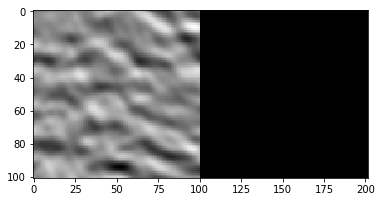

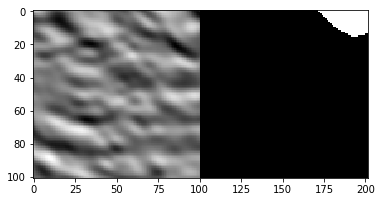

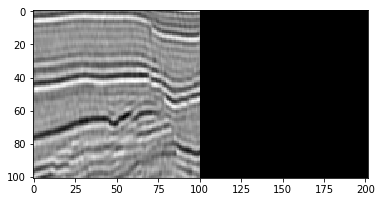

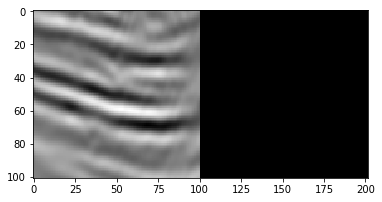

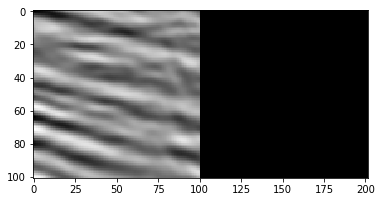

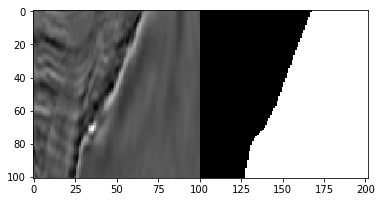

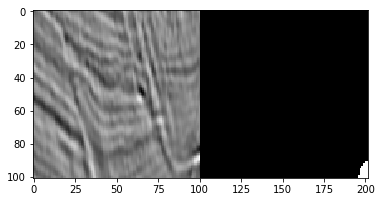

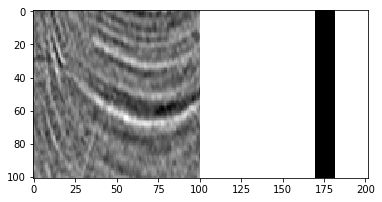

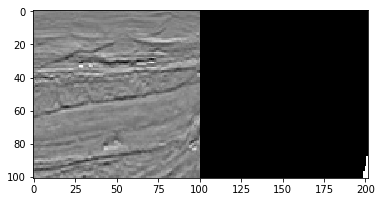

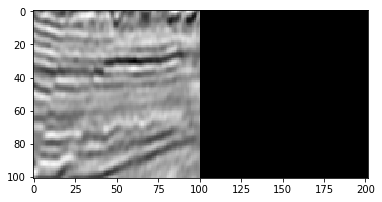

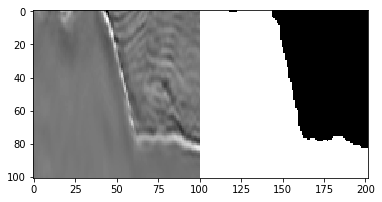

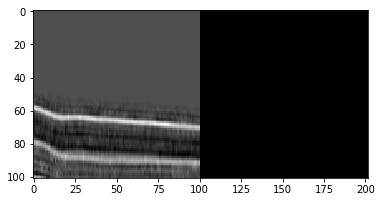

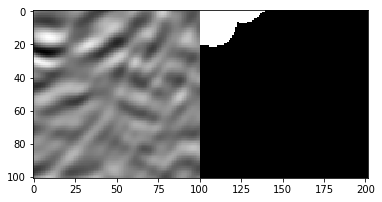

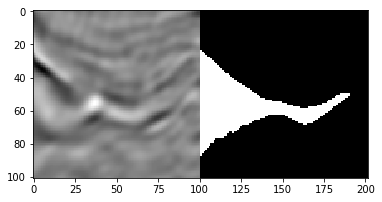

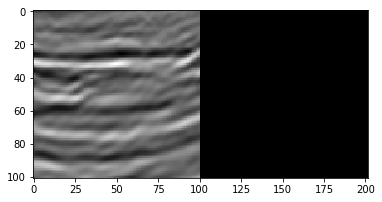

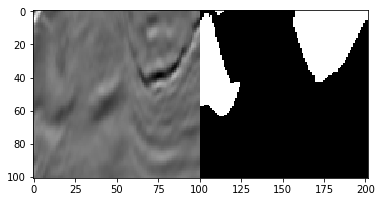

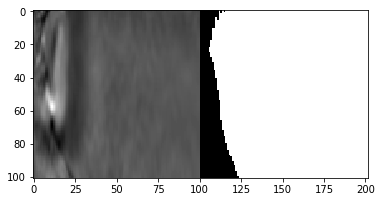

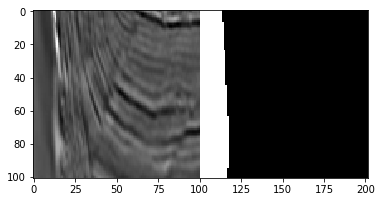

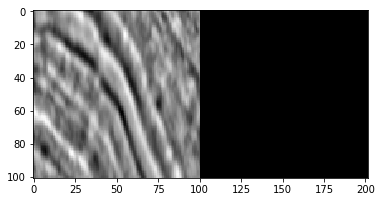

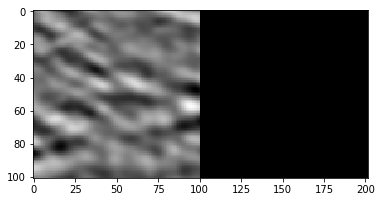

In [4]:
for i in range(20):
    plt.figure()
    plt.imshow(np.concatenate((train_imgs[i], train_masks[i]), axis=1),cmap='gray')

## 5 fold cross validation

In [5]:
ps=np.array([101,101])
cs=np.array([64,64])
ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])


In [6]:



def get_101_img_to_64(np_array):
    ps=np.array([101,101])
    cs=np.array([64,64])
    ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])
       
    
    np_array_1=np_array[:,:cs[0],:cs[0]]
    np_array_2=np_array[:,-cs[0]:,:cs[0]]
    np_array_3=np_array[:,:cs[0],-cs[0]:]
    np_array_4=np_array[:,-cs[0]:,-cs[0]:]
    np_array_mid=np_array[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]

    np_array_all=np.concatenate([np_array_1,np_array_2,np_array_3,np_array_4,np_array_mid],axis=0)

    print("Input shape : ",np_array.shape,"Output shape : ",np_array_all.shape)
    return np_array_all


# X_train.shape,get_101_img_to_64(X_train)

In [7]:
# train test split
df_train=pd.DataFrame()
df_train["imgs"]=train_imgs
df_train["depths"]=list_depths#[[[x]*128]*128 for x in list_depths]

print(set([ceil(x.flatten().sum()/(101.0*101.0*255)*10) for x in train_masks]))


from sklearn.model_selection import train_test_split
df_X_train, df_X_test, y_train, y_test = train_test_split(df_train, train_masks, test_size=0.25, random_state=45,
                                                          stratify=[ceil(x.flatten().sum()/(101.0*101.0*255)) for x in train_masks])



## Prepare and Add augmentated data to training sample

# df_X_train_aug=pd.DataFrame(columns=['imgs','depths'])
# df_X_train_aug['imgs']=train_imgs_aug
# df_X_train_aug['depths']=list_depths_aug

# df_X_train=pd.concat([df_X_train,df_X_train_aug],axis=0)
# y_train=y_train+train_masks_aug


#normalize data
X_train=np.array(df_X_train['imgs'].values.tolist())
X_test=np.array(df_X_test['imgs'].values.tolist())
X_test_101_org=X_test.copy()
X_train=get_101_img_to_64(X_train)
X_test=get_101_img_to_64(X_test)


X_train = X_train.astype('float32') / 255.-0.5
X_test = X_test.astype('float32') / 255.-0.5
X_train = np.reshape(X_train, (len(X_train), 64, 64, 1))    # adapt this if using 'channels_first' image data format
X_test = np.reshape(X_test, (len(X_test), 64, 64, 1))


y_train=np.array(y_train)
y_test=np.array(y_test)
y_test_101_org=y_test.copy()
y_train=get_101_img_to_64(y_train)
y_test=get_101_img_to_64(y_test)

y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.
y_train = np.reshape(y_train, (len(y_train), 64, 64, 1))    # adapt this if using 'channels_first' image data format
y_test = np.reshape(y_test, (len(y_test), 64, 64, 1))

df_X_train.shape,df_X_test.shape,len(y_train),len(y_train[0])
# y_train


{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10}
Input shape :  (2940, 101, 101) Output shape :  (14700, 64, 64)
Input shape :  (980, 101, 101) Output shape :  (4900, 64, 64)
Input shape :  (2940, 101, 101) Output shape :  (14700, 64, 64)
Input shape :  (980, 101, 101) Output shape :  (4900, 64, 64)


((2940, 2), (980, 2), 14700, 64)

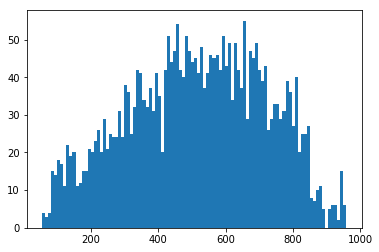

In [8]:
plt.hist(df_X_train["depths"].values, bins=100)
plt.show()

In [9]:
# batch_size = 128
epochs = 50
inChannel = 1
row_len, col_len = 64, 64
input_img = Input(shape = (3200,row_len, col_len, inChannel))
max_depths=max(list_depths)



#define variable input depth metrices
def get_depths_arr(list_depths,row_len,max_depths):
    out=[[[x]*row_len]*row_len for x in list_depths]*5
    out=np.array(out).astype('float32')/float(max_depths)
    out = np.reshape(out, (len(list_depths)*5, row_len, row_len, 1))
    print(out.shape,"123")
    return out

# get_depths_arr(df_X_train['depths'].values.tolist(),23,max_depths)


In [10]:


# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)



In [11]:

from resnet50_d import identity_block
from resnet50_d import conv_block

In [110]:
input_img = Input(shape=(64,64, 1))    # adapt this if using 'channels_first' image data format

depth_input_8 = Input(shape=(8,8, 1), name='depth_input_8')
depth_input_16 = Input(shape=(16,16, 1), name='depth_input_16')
depth_input_32 = Input(shape=(32,32, 1), name='depth_input_32')
depth_input_64 = Input(shape=(64,64, 1), name='depth_input_64')
# depth_input_128 = Input(shape=(128,128, 1), name='depth_input_128')

## BLOCK == "a"
conv1_1= Conv2D(16, 3, activation='relu', padding='same')(input_img)
# conv1_2= Conv2D(8, 3, activation='relu', padding='same')(conv1_1)
conv1_2=identity_block(conv1_1, 3, [4,4,16], stage=1, block='a')
# pool_1 = MaxPooling2D((2, 2), padding='same')(conv1_2)
pool_1=conv_block(conv1_2, 3, [4,4,16], stage=1, block='a')
pool_1=Dropout(0.5)(pool_1)


## BLOCK == "b"
conv2_1= Conv2D(32, 3, activation='relu', padding='same')(pool_1)
# conv2_2= Conv2D(16, 3, activation='relu', padding='same')(conv2_1)
conv2_2=identity_block(conv2_1, 3, [8,8,32], stage=2, block='b')
# pool_2= MaxPooling2D((2, 2), padding='same')(conv2_2)
pool_2=conv_block(conv2_2, 3, [8,8,32], stage=2, block='b')
pool_2=Dropout(0.5)(pool_2)


## BLOCK == "c"
conv3_1= Conv2D(64, 3, activation='relu', padding='same')(pool_2)
# conv3_2= Conv2D(32, 3, activation='relu', padding='same')(conv3_1)
conv3_2=identity_block(conv3_1, 3, [16,16,64], stage=2, block='c')
# pool_3= MaxPooling2D((2, 2), padding='same')(conv3_2)
pool_3=conv_block(conv3_2, 3, [16,16,64], stage=2, block='c')
pool_3=Dropout(0.5)(pool_3)

## BLOCK == "d"
conv4_1= Conv2D(64, 3, activation='relu', padding='same')(pool_3)
# conv4_2= Conv2D(32, 3, activation='relu', padding='same')(conv4_1)
conv4_2=identity_block(conv4_1, 3, [16,16,64], stage=2, block='d')
# encoded = MaxPooling2D((2, 2), padding='same')(conv4_2)
encoded=conv_block(conv4_2, 3, [16,16,64], stage=2, block='d')



# at this point the representation is (4, 4, 8), i.e. 128-dimensional

up4_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same') (encoded)
merge_4=concatenate([up4_1, conv4_2,depth_input_8])
# merge_4=Dropout(0.2)(merge_4)
up4_2 = Conv2D(64, 3, activation='relu', padding='same')(merge_4)
up4_3 = Conv2D(64, 3, activation='relu', padding='same')(up4_2)


up3_1 = Conv2DTranspose(64, 2, strides=(2, 2), padding='same') (up4_3)
merge_3=concatenate([up3_1, conv3_2])
# merge_3=concatenate([up3_1, conv3_2,depth_input_16])
# merge_3=Dropout(0.2)(merge_3)
up3_2 = Conv2D(64, 3, activation='relu', padding='same')(merge_3)
up3_3 = Conv2D(64, 3, activation='relu', padding='same')(up3_2)


up2_1 = Conv2DTranspose(32, 2, strides=(2, 2), padding='same') (up3_3)
merge_2=concatenate([up2_1, conv2_2])
# merge_2=concatenate([up2_1, conv2_2,depth_input_32])
# merge_2=Dropout(0.2)(merge_2)
up2_2 = Conv2D(32, 3, activation='relu', padding='same')(merge_2)
up2_2 = Conv2D(32, 3, activation='relu', padding='same')(up2_2)



up1_1 = Conv2DTranspose(16, 2, strides=(2, 2), padding='same')(up2_2)
merge_1=concatenate([up1_1, conv1_2])
# merge_1=concatenate([up1_1, conv1_2,depth_input_64])
# merge_1=Dropout(0.2)(merge_1)
up1_2 = Conv2D(16, 3, activation='relu', padding='same')(merge_1)
up1_3 = Conv2D(16, 3, activation='relu', padding='same')(up1_2)


up0_0 = Conv2D(8, 2, activation='relu', padding='same')(up1_3)
up0_1 = Conv2D(1, 1, activation="sigmoid", padding='same')(up0_0)


autoencoder = Model(inputs=[input_img, depth_input_8], outputs=[up0_1])

autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 64, 64, 16)   160         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 64, 64, 4)    68          conv2d_43[0][0]                  
__________________________________________________________________________________________________
batch_normalization_29 (BatchNo (None, 64, 64, 4)    16          conv2d_44[0][0]                  
__________________________________________________________________________________________________
activation

In [112]:
from keras.models import load_model
# autoencoder.save('autoencode_test.h5')
# autoencoder=load_model('model-tgs-salt-4-1.h5', custom_objects={'mean_iou': mean_iou})

from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

autoencoder.compile(optimizer="adam", loss='binary_crossentropy', metrics=[mean_iou] )


In [113]:
earlystopper = EarlyStopping(patience=15, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=10, min_lr=0.001, verbose=1)
checkpointer = ModelCheckpoint('model-tgs-salt_res_2-1.h5', verbose=1, save_best_only=True)


## define5 fold validation 

In [ ]:
autoencoder_train = autoencoder.fit([X_train,
                                     get_depths_arr(df_X_train['depths'].values.tolist(),8,max_depths)],
                                    [y_train], 
                                    batch_size=200,
                                    epochs=100,
                                    verbose=1,
                                    validation_data=(
                                        [X_test,get_depths_arr(df_X_test['depths'].values.tolist(),8,max_depths)],
                                        [y_test]),
                                    
                                    callbacks=[earlystopper, checkpointer,reduce_lr])

(14700, 8, 8, 1) 123
(4900, 8, 8, 1) 123
Train on 14700 samples, validate on 4900 samples
Epoch 1/100
14700/14700 [==============================] - 89s 6ms/step - loss: 0.4773 - mean_iou: 0.3684 - val_loss: 0.5344 - val_mean_iou: 0.3882

Epoch 00001: val_loss improved from inf to 0.53445, saving model to model-tgs-salt_res_2-1.h5
Epoch 2/100
14700/14700 [==============================] - 344s 23ms/step - loss: 0.3553 - mean_iou: 0.4310 - val_loss: 0.5978 - val_mean_iou: 0.4802

Epoch 00002: val_loss did not improve
Epoch 3/100
14700/14700 [==============================] - 348s 24ms/step - loss: 0.3180 - mean_iou: 0.5105 - val_loss: 0.4401 - val_mean_iou: 0.5338

Epoch 00003: val_loss improved from 0.53445 to 0.44010, saving model to model-tgs-salt_res_2-1.h5
Epoch 4/100
14700/14700 [==============================] - 189s 13ms/step - loss: 0.3043 - mean_iou: 0.5504 - val_loss: 0.5993 - val_mean_iou: 0.5609

Epoch 00004: val_loss did not improve
Epoch 5/100
14700/14700 [===============

# Prepare dividing array

In [106]:
def get_101_dividing_np_array():
    ps=np.array([101,101])
    cs=np.array([64,64])
    ch_mid_idx=np.array([int((ps[0]-cs[0])/2),int((ps[0]-cs[0])/2)+cs[0]])
    
    

    child_1=np.zeros(cs)+1
    child_2=np.zeros(cs)+1
    child_3=np.zeros(cs)+1
    child_4=np.zeros(cs)+1
    child_mid=np.zeros(cs)+1
    
    all_child_array=np.zeros((101,101),dtype=float)
    all_child_array[:cs[0],:cs[0]]=all_child_array[:cs[0],:cs[0]]+child_1
    all_child_array[-cs[0]:,:cs[0]]=all_child_array[-cs[0]:,:cs[0]]+child_2
    all_child_array[:cs[0],-cs[0]:]=all_child_array[:cs[0],-cs[0]:]+child_3
    all_child_array[-cs[0]:,-cs[0]:]=all_child_array[-cs[0]:,-cs[0]:]+child_4

    all_child_array[ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=all_child_array[ch_mid_idx[0]:ch_mid_idx[1],
                                                                                             ch_mid_idx[0]:ch_mid_idx[1]]+child_mid
    
    return all_child_array


## prepare for X_test prediction 

In [107]:
autoencoder=load_model('model-tgs-salt_res_2-1.h5', custom_objects={'mean_iou': mean_iou})

pred_imgs_64=autoencoder.predict([X_test,
                              get_depths_arr(df_X_test['depths'].values.tolist(),8,max_depths)],verbose=1)

preds_img_101=np.zeros((int(X_test.shape[0]/5),101,101),dtype=float)
preds_img_101[:,:cs[0],:cs[0]]=preds_img_101[:,:cs[0],:cs[0]]+pred_imgs_64[0:preds_img_101.shape[0],:,:,0]
preds_img_101[:,-cs[0]:,:cs[0]]=preds_img_101[:,-cs[0]:,:cs[0]]+pred_imgs_64[preds_img_101.shape[0]:preds_img_101.shape[0]*2,:,:,0]
preds_img_101[:,:cs[0],-cs[0]:]=preds_img_101[:,:cs[0],-cs[0]:]+pred_imgs_64[preds_img_101.shape[0]*2:preds_img_101.shape[0]*3,:,:,0]
preds_img_101[:,-cs[0]:,-cs[0]:]=preds_img_101[:,-cs[0]:,-cs[0]:]+pred_imgs_64[preds_img_101.shape[0]*3:preds_img_101.shape[0]*4,:,:,0]

preds_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=preds_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]+pred_imgs_64[preds_img_101.shape[0]*4:preds_img_101.shape[0]*5,:,:,0]


preds_img_101_c=preds_img_101/get_101_dividing_np_array()*255.0#+127.5
# preds_img_101=(preds_img_101>127.5).astype(np.uint8)





(4900, 8, 8, 1) 123
4900/4900 [==============================] - 7s 2ms/step


In [108]:
preds_img_101_c#255

def get_iou_of_perdict_vs_actual(pred,actual):
    list_th_iou=[]
    for th in range(0,255,5):
        pred_th=pred>th
#         print(actual)
#         plt.figure()
#         plt.imshow(np.concatenate((actual*255,pred_th*255,pred), axis=1),cmap='gray')
      
    
        intersection=np.logical_and(pred_th,actual)
        union=np.logical_or(pred_th,actual)
        if float(np.sum(union))==0:
            iou=1.0
        else:
            iou=float(np.sum(intersection))/float(np.sum(union)) 
            iou =iou if iou>0.5 else 0
            
        list_th_iou.append(iou)
#         plt.figure()
#         print(pred_th*255)
#         plt.imshow(np.concatenate((actual*255,pred_th*255,pred,intersection*255,union*255), axis=1),cmap='gray')
        
    return list_th_iou


list_list_th_iou=[]
for i in range(750):#preds_img_101_c.shape[0]
    img=preds_img_101_c[i]
    list_list_th_iou.append(get_iou_of_perdict_vs_actual(img,y_test_101_org[i]/255))

list_list_th_iou

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0],
 [0,
  0.6336173508907823,
  0.7310098302055407,
  0.7768281101614435,
  0.8067061143984221,
  0.8313008130081301,
  0.8485477178423236,
  0.8556485355648535,
  0.8583420776495279,
  0.8691489361702127,
  0.8822894168466523,
  0.8869565217391304,
  0.893640350877193,
  0.898566703417861,
  0.9035476718403548,
  0.9042316258351893,
  0.907

(145, 0.6675553819562671)

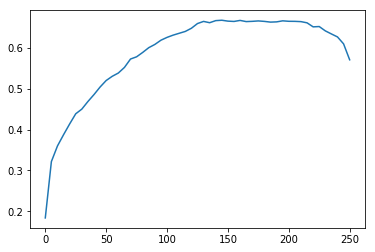

In [109]:
def Average(lst): 
    return sum(lst) / len(lst) 

list_iou=[Average(x) for x in np.array(list_list_th_iou).T.tolist()]
plt.plot(range(0,255,5),list_iou)

intensity_th=range(0,255,5)[list_iou.index(max(list_iou))]
intensity_th,max(list_iou)

In [85]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs
    
    
    
    
"""
OPTION-2
used for converting the decoded image to rle mask

"""
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)



# pred_dict = {fn[:-4]:RLenc(np.round(preds_test_upsampled[i])) for i,fn in tqdm_notebook(enumerate(test_ids))}
# sub = pd.DataFrame.from_dict(pred_dict,orient='index')
# sub.index.names = ['id']
# sub.columns = ['rle_mask']
# sub.to_csv('submission.csv')

# prepare final predictions for submission

In [102]:
# import all images

X_preds=[]
X_preds_img_id=[]
list_X_preds_depths=[]

output_blank_id=[]


for i,img_path in enumerate(glob(PATH+"\\data\\test\\images\\*")):
    img_id=os.path.basename(os.path.normpath(img_path.split(".")[0]))
    n=np.array(cv2.imread(img_path))
    
    if np.average(n)!=0:
        n=cv2.resize(n,(101,101),interpolation = cv2.INTER_CUBIC)
        n = cv2.cvtColor(n,cv2.COLOR_BGR2GRAY).astype('float32') / 255.-0.5
        n_depth=df_depth[df_depth["id"]==img_id+".png"]['z'].values[0]
        
        X_preds_img_id.append(img_id)
        X_preds.append(n)
        list_X_preds_depths.append(n_depth)
        
    else:
        output_blank_id.append(img_id)

# X_preds Prepareations 
X_preds = np.array(X_preds)
X_preds = get_101_img_to_64(X_preds)
X_preds = np.reshape(X_preds, (len(X_preds), 64, 64, 1))

# import model and then use that mosel to predict images

submi_img_64=autoencoder.predict([X_preds,
                              get_depths_arr(list_X_preds_depths,8,max_depths)],verbose=1)



submi_img_101=np.zeros((int(X_preds.shape[0]/5),101,101),dtype=float)
submi_img_101[:,:cs[0],:cs[0]]=submi_img_101[:,:cs[0],:cs[0]]+submi_img_64[0:submi_img_101.shape[0],:,:,0]
submi_img_101[:,-cs[0]:,:cs[0]]=submi_img_101[:,-cs[0]:,:cs[0]]+submi_img_64[submi_img_101.shape[0]:submi_img_101.shape[0]*2,:,:,0]
submi_img_101[:,:cs[0],-cs[0]:]=submi_img_101[:,:cs[0],-cs[0]:]+submi_img_64[submi_img_101.shape[0]*2:submi_img_101.shape[0]*3,:,:,0]
submi_img_101[:,-cs[0]:,-cs[0]:]=submi_img_101[:,-cs[0]:,-cs[0]:]+submi_img_64[submi_img_101.shape[0]*3:submi_img_101.shape[0]*4,:,:,0]

submi_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]=submi_img_101[:,ch_mid_idx[0]:ch_mid_idx[1],ch_mid_idx[0]:ch_mid_idx[1]]+submi_img_64[submi_img_101.shape[0]*4:submi_img_101.shape[0]*5,:,:,0]


submi_img_101_c=submi_img_101/get_101_dividing_np_array()*255.0
submi_img_101_c=(submi_img_101_c>155).astype(np.uint8)

output_X_submi=[RLenc(submi_img_101_c[i], order='F', format=True) for i in range(len(submi_img_101_c))]



Input shape :  (17570, 101, 101) Output shape :  (87850, 64, 64)
(87850, 8, 8, 1) 123
87850/87850 [==============================] - 64s 727us/step


In [104]:
submi_img_101_c=submi_img_101/get_101_dividing_np_array()*255.0
submi_img_101_c=(submi_img_101_c>127.5).astype(np.uint8)

output_X_submi=[RLenc(submi_img_101_c[i], order='F', format=True) for i in range(len(submi_img_101_c))]

In [103]:
sub = pd.DataFrame()
sub['id']=X_preds_img_id + output_blank_id
sub['rle_mask']=output_X_submi + [np.nan for i in range(len(output_blank_id))]

sub.to_csv('submission2.csv',index=False)
sub

,id,rle_mask
0,0005bb9630,
1,000a68e46c,
2,000c8dfb2a,65 15 81 2 142 1 145 3 166 11 178 8 243 8 267 ...
3,000d0a5f6c,2544 7 2645 9 2746 9 2847 10 2948 9 2958 1 304...
4,001ef8fc87,1 7269 7273 84 7360 1 7374 81 7475 76 7552 1 7...
5,002124aa19,2619 6 2713 1 2715 13 2810 19 2906 24 3003 28 ...
6,002af5d1e8,7983 13 8081 18 8182 18 8283 34 8384 37 8485 4...
7,00323f1910,25 15 82 8 126 16 183 7 227 15 279 13 329 13 3...
8,00329dc15c,
9,0041cb8c49,1 1613 1617 96 1718 94 1819 93 1920 83 2006 3 ...


In [98]:
(submi_img_101/get_101_dividing_np_array())[0:10].flatten().round(2).max()

194.92